In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from itertools import combinations

In [47]:
df = pd.read_csv(r'Historical Crypto Prices', index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,Bitcoin,Binance,Cardano,Ethereum,Solana,XRP
Date,,,,,,
2020-07-13,9243.6,18.42,0.1244,239.73,1.279,0.1987
2020-07-14,9253.4,18.09,0.1324,240.50,1.115,0.1991
2020-07-15,9198.7,17.63,0.1306,238.62,1.383,0.1972
2020-07-21,9387.3,17.72,0.1231,245.53,1.004,0.1995
2020-07-22,9513.7,18.10,0.1238,263.28,1.046,0.2036


In [48]:
tickers = list(df.columns)
weight = {ticker: 100/len(tickers) for ticker in tickers}

def calculate_investment_price(values, initial_value, base_value):
    total_value = sum(values.values())
    return ((total_value / initial_value) * base_value)

transaction_fee_rate = .0003
initial_investment = 1000000
base_value = 100

initial_shares = {
    ticker: ((initial_investment * weight[ticker]) / df[ticker].iloc[0]) for ticker in tickers
}

# double check initial values 
initial_values = {
    ticker: (initial_shares[ticker] * df[ticker].iloc[0]) for ticker in tickers
}
initial_total_value = sum(initial_values.values())

index_price = [base_value]

for i in range(1, len(df)):
    # calculate current investment value for each asset 
    investment_per_stock = {
        ticker: (initial_shares[ticker] * df[ticker].iloc[i]) for ticker in tickers
    }

    total_investment = sum(investment_per_stock.values())

    # quarterly rebalance
    if i % 63 == 0:
        target_investment_per_stock = {
            ticker: (total_investment * weight[ticker]) for ticker in tickers
        }

        # calculate expected fees, i.e. the cost of rebalancing
        potential_fees = 0
        for ticker in tickers:
            target_shares = (target_investment_per_stock[ticker] / df[ticker].iloc[i])
            delta_shares = abs(target_shares - initial_shares[ticker])
            potential_fees += (delta_shares * df[ticker].iloc[i] * transaction_fee_rate)
        
        adjusted_total_investment = total_investment - potential_fees

        for ticker in tickers:
            target_investment_per_stock[ticker] = adjusted_total_investment * weight[ticker]
            initial_shares[ticker] = target_investment_per_stock[ticker] / df[ticker].iloc[i]
    
    # calculate the index price
    price = calculate_investment_price(investment_per_stock, initial_total_value, base_value)
    index_price.append(price)

index_price = pd.DataFrame(index_price)
index_price.rename(columns={0: 'Price'}, inplace=True)
index_price

,Price
0,1.000000e+02
1,9.874089e+01
2,1.011871e+02
3,9.633836e+01
4,9.912911e+01
...,...
1600,3.101327e+53
1601,3.138639e+53
1602,2.784862e+53
1603,2.835585e+53


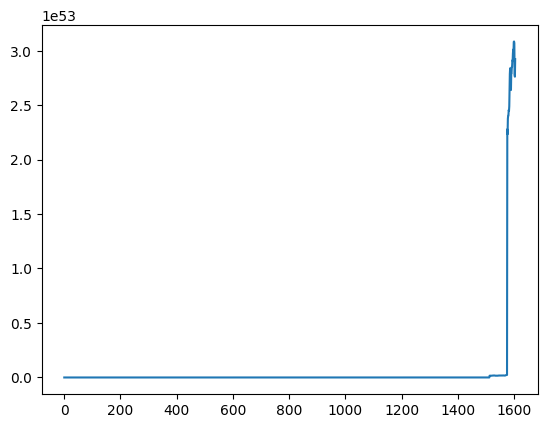

In [45]:
plt.plot(index_price["Price"])